# Titanic kaggle competition

# Descritpion 

In [1]:
import pandas as pd
import numpy as np
import sklearn
import mglearn
import matplotlib.pyplot as plt
import seaborn as sns

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
!ls

README.md             gender_submission.csv titanic_train.ipynb
cache                 test.csv              train.csv


In [4]:
!head test.csv

In [5]:
df = pd.read_csv("train.csv")
df.shape

(891, 12)

In [8]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [9]:
y = df[["Survived"]]
y.tail(3)

,Survived
888,0
889,1
890,0


#  Utils methods

In [104]:
def get_title_category(title):
    if title in ["Jonkheer"]:
        return "Low"
    elif title in ["Mr", "Miss", "Mrs", "Mlle", "Ms", "Mme"]:
        return "Normal"
    elif title in ["Col", "Major", "Capt"]:
        return "Militar"
    elif title in ["Dr", "Rev"]:
        return "Rel/Med"
    elif title in ["Master", "Countess", "Sir", "Lady", "Don", "Dona"]:
        return "Aristocracy"
    else :
        return "Other"

In [105]:
def set_median_values(df):
    """ In this method we got 3 differents val for Age: mean, median and one mean per title"""
    mean_age = df.Age.mean(axis=0)
    median_age = df.Age.median()
    median_fare = np.nanmedian(df.Fare)
    mean_age, median_age
    mean_count_val = 4
    title_class_mean_age = df.groupby(['Title', 'Pclass']).agg({"Age":["count", "mean"]})
    title_class_mean_age_dict = title_class_mean_age[title_class_mean_age[('Age','count')] > mean_count_val][('Age', 'mean')].to_dict()
    title_class_mean_age_dict
    return mean_age, median_age, title_class_mean_age_dict
#np.mean(df.Age), np.nanmedian(df.Age)
#np.mean(df.Fare), np.nanmedian(df.Fare), df.Fare.median()

In [106]:
def fill_title_age(title, pclass):
    if (title, pclass) in title_class_mean_age_dict.keys():
        return title_class_mean_age_dict[(title, pclass)]
    return mean_age

# Replace per Age/Category Average
def replace_average_age(df, is_age_title_average, mean_df_age):
    if(is_age_title_average):
        print("true") 
        df[df.Age.isna()==True,"Age"] = df[df.Age.isna()==True].apply(lambda x:fill_title_age(x["Title"], x["Pclass"]), axis=1)
    else:
        #df[df.Age.isna()==True].Age = df.Age.fillna(mean_age)
        df.Age.fillna(mean_df_age, inplace=True)

In [107]:
def prepare_data(df, is_train_df=True, mean_df_age=None, title_class_mean_age_dict=None, cat_col_dum=None, cols_to_use=None):
    # Add title col
    df["Title"]= df.Name.str.extract('([A-Za-z]+)\.')
    df.Title = df.Title.apply(get_title_category)
    # median values 
    if is_train_df:
        mean_df_age, median_df_age, title_class_mean_age_dict = set_median_values(df)
    
    is_age_title_average = False
    replace_average_age(df, is_age_title_average, mean_df_age )
    
    new_df = df
    if "Survived" in df.columns:
        new_df = df.drop(columns=["Survived"])

    catecorgies_col = ["Pclass","Sex","Embarked", "Title"]
    new_df = pd.get_dummies(new_df, columns=catecorgies_col)
    
    if is_train_df:
        cat_col_dum = []
        for col in new_df.columns:
            if col not in df.columns:
                cat_col_dum.append(col)
    else:
        # Test DF => need to control all dumies colums are present
        for col in cat_col_dum:
            if col not in new_df.columns:
                new_df[col] = 0
    
    if is_train_df:
        x_cols = [col for col in new_df.columns if new_df[col].dtype=='float64' or new_df[col].dtype=='int64' 
             or new_df[col].dtype=='uint8' ]
        labels = []
        values = []
        for col in x_cols:
            labels.append(col)
            values.append(np.corrcoef(new_df[col],y.Survived.values)[0,1])
        corr_df = pd.DataFrame({"col_labels":labels, "corr_values":values})
        corr_df = corr_df.sort_values(by="corr_values")
        corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.02)]
        cols_to_use = corr_df_sel.col_labels.tolist()

    selected_col_df = new_df[cols_to_use]
    return selected_col_df, mean_df_age, title_class_mean_age_dict, cat_col_dum, cols_to_use

In [108]:
# Not used I"m not sure how to use it
def train_data(model, is_complete_train=True):
    df = pd.read_csv("train.csv")
    y = df[["Survived"]]
    df, y = prepare_training_data(df, is_train_df=True)

    is_complete_train = True
    if is_complete_train:
        model.fit(selected_col_df, y)
    return model

# 0- Data  vizualisation

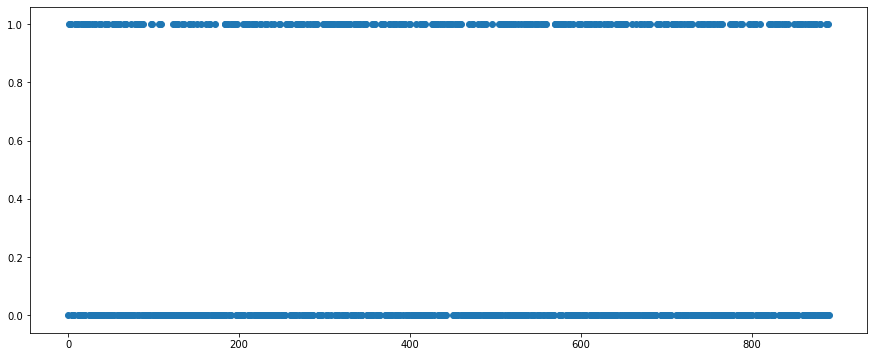

In [15]:
plt.figure(figsize=(15,6))
plt.scatter(np.arange(df.shape[0]),y["Survived"].values)
plt.show()

In [16]:
y["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [17]:
survived_df = df[df["Survived"]==1]
not_survived_df = df[df["Survived"]==0]

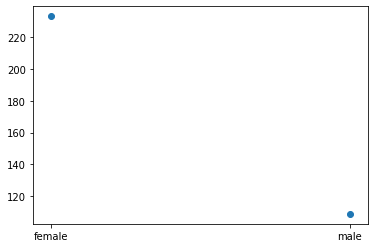

In [20]:
plt.scatter(survived_df.Sex.value_counts().keys(), survived_df.Sex.value_counts())
plt.show()

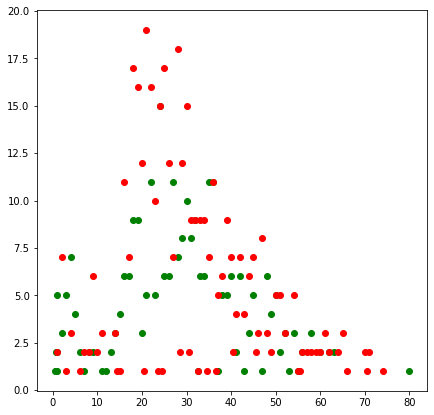

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(survived_df.Age.value_counts().keys(), survived_df.Age.value_counts(), c="green")
plt.scatter(not_survived_df.Age.value_counts().keys(), not_survived_df.Age.value_counts(), c="red")
plt.show()

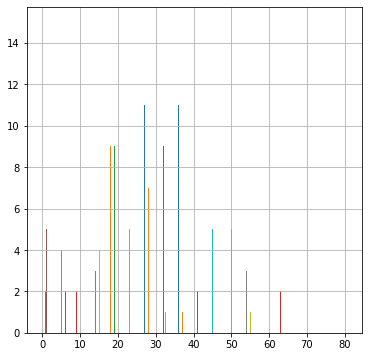

In [23]:
plt.figure(figsize=(6,6))
survived_df.groupby('Age').Age.hist()
plt.show()

In [25]:
bins = np.linspace(0, 70, 7)
def get_group_age(age, bins):
    if np.isnan(age):
        return -1
    if age:
        return np.digitize(age,bins=bins)

survived_df["groupAge"] = survived_df["Age"].apply(lambda x:get_group_age(x,bins))
not_survived_df["groupAge"] = not_survived_df["Age"].apply(lambda x:get_group_age(x,bins))

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [29]:
survived_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,groupAge
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2


In [30]:
not_survived_df['groupAge'].value_counts()

 3    140
-1    125
 2    114
 4     81
 5     39
 1     29
 6     15
 7      6
Name: groupAge, dtype: int64

(0, 150)

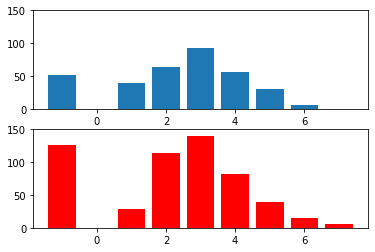

In [31]:
fig, axes = plt.subplots(nrows=2,ncols=1)
axes[0].bar(survived_df['groupAge'].value_counts().keys(),survived_df['groupAge'].value_counts())
axes[0].set_ylim([0,150])
axes[1].bar(not_survived_df['groupAge'].value_counts().keys(),not_survived_df['groupAge'].value_counts(), color='red')
axes[1].set_ylim([0,150])

In [32]:
survived_df.groupAge= survived_df.groupAge.map({1:"0-10", 2:"10-20", 3:"20-30", 4:"30-40", 5:"40-50",6:"50-60", 7:"60-70", -1:"Unknow"})

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
survived_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,groupAge
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30-40
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,20-30
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30-40
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,20-30
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,10-20


In [34]:
survived_df['groupAge'].value_counts().keys()

Index(['20-30', '10-20', '30-40', 'Unknow', '0-10', '40-50', '50-60', '60-70'], dtype='object')

(0, 150)

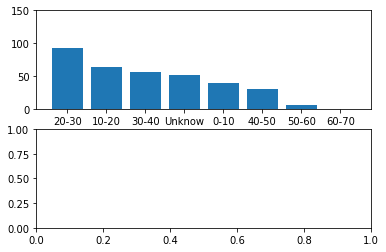

In [35]:
fig, axes = plt.subplots(nrows=2,ncols=1)
axes[0].bar(survived_df['groupAge'].value_counts().keys(),survived_df['groupAge'].value_counts())
axes[0].set_ylim([0,150])


In [36]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [37]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [38]:
df.Cabin.value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
D              3
C22 C26        3
              ..
D15            1
C54            1
A36            1
C101           1
B42            1
Name: Cabin, Length: 147, dtype: int64

In [39]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

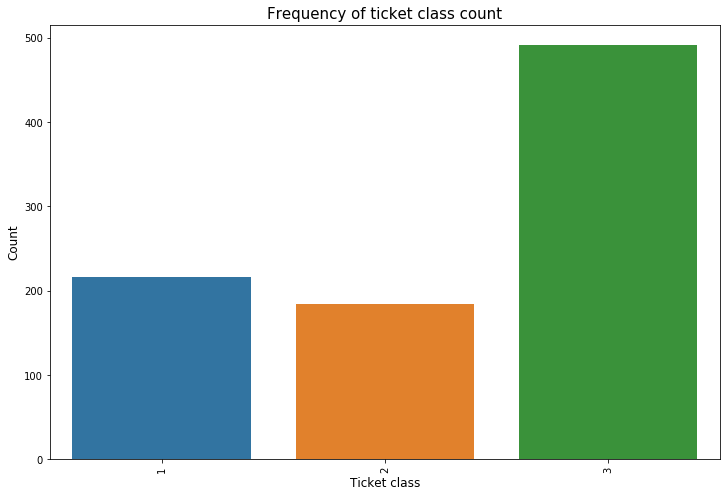

In [129]:
plt.figure(figsize=(12,8))
sns.countplot(x="Pclass", data=df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ticket class', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of ticket class count", fontsize=15)
plt.show()
#same as :
#plt.bar(df["Pclass"].value_counts().keys(),df["Pclass"].value_counts())
#plt.show()

In [130]:
df["Ticket"].value_counts()

1601        7
347082      7
CA. 2343    7
CA 2144     6
347088      6
           ..
347743      1
PC 17754    1
2695        1
113055      1
349213      1
Name: Ticket, Length: 681, dtype: int64

In [131]:
len(df["Ticket"].value_counts())

681

In [132]:
# maybe it will be interesting to use ticket val with interval val
#  0 < TicketNb < 100 000 
# 100 000 < TicketNB < 200 000 ...;
# see repartition of ticket value

# 1- Data preprocessing

## Focus on name to get a title category

In [33]:
df.Name.str.extract('([A-Za-z]+)\.')[0].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Mme           1
Capt          1
Jonkheer      1
Countess      1
Sir           1
Ms            1
Lady          1
Don           1
Name: 0, dtype: int64

In [34]:
df["Title"]= df.Name.str.extract('([A-Za-z]+)\.')

In [35]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [6]:
# def get_title_category(title) see utils part

In [37]:
df.Title = df.Title.apply(get_title_category)

In [38]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Normal
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Normal
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Normal
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Normal
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Normal


## Ticket category 

In [128]:
df.Ticket.tail(40)

851              347060
852                2678
853            PC 17592
854              244252
855              392091
856               36928
857              113055
858                2666
859                2629
860              350026
861               28134
862               17466
863            CA. 2343
864              233866
865              236852
866       SC/PARIS 2149
867            PC 17590
868              345777
869              347742
870              349248
871               11751
872                 695
873              345765
874           P/PP 3381
875                2667
876                7534
877              349212
878              349217
879               11767
880              230433
881              349257
882                7552
883    C.A./SOTON 34068
884     SOTON/OQ 392076
885              382652
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, dtype: object

In [34]:
# What to do with Ticket ???

## Confusion matrice 

In [35]:
confusion_df = df.copy()

In [36]:
confusion_df.drop(columns=["PassengerId", "Name"], inplace=True)

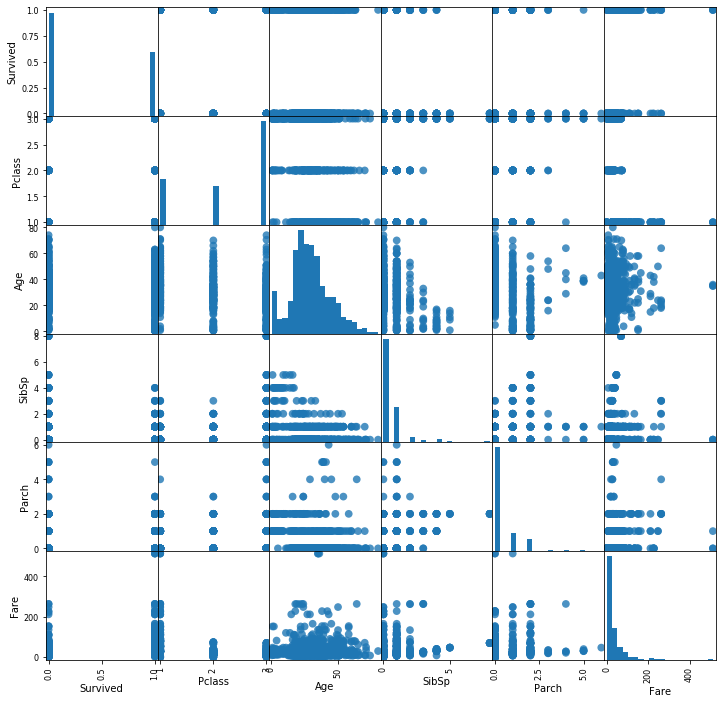

In [37]:
pd.plotting.scatter_matrix(
    confusion_df, figsize=(12,12),
    marker='o', hist_kwds= {'bins':20},s=60, alpha=.8, cmap=mglearn.cm3
)
plt.show()

In [42]:
df.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

In [43]:
# what is the role of cabin if 687 are null over 891 ....

## Mean and Nan values 

In [11]:
# def set_median_values(df) see Utils part

In [40]:
mean_age, median_age, title_class_mean_age_dict = set_median_values(df)

In [42]:
df[df.Age.isna()==True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Normal
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Normal
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Normal
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Normal
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,Normal
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,Normal
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,Normal
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,Normal


In [18]:
# def fill_title_age(title, pclass): see Utils part

# Replace per Age/Category Average
#def replace_average_age(df, is_age_title_average, mean_df_age): see Utils part

In [45]:
is_age_title_average = False
replace_average_age(df, is_age_title_average, mean_age)

ekse


In [46]:
df.loc[df.Age.isna()==True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [47]:
#df[df.Age.isna()==True].apply(lambda x:fill_age(x["Title"], x["Pclass"]), axis=1) # Not working
#df.loc[df.Age.isna()==True,"Age"] = df[df.Age.isna()==True].apply(lambda x:fill_age(x["Title"], x["Pclass"]), axis=1)  working

In [48]:
new_df = df.drop(columns=["Survived"])
new_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Normal
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Normal
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Normal
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Normal
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Normal


## Generate Categories columns and select relevant columns

In [49]:
catecorgies_col = ["Pclass","Sex","Embarked", "Title"]
new_df = pd.get_dummies(new_df, columns=catecorgies_col)

In [50]:
# get all my dummies column
cat_col_dum = []
for col in new_df.columns:
    if col not in df.columns:
        cat_col_dum.append(col)

In [51]:
cat_col_dum

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title_Aristocracy',
 'Title_Low',
 'Title_Militar',
 'Title_Normal',
 'Title_Rel/Med']

In [52]:
new_df.dtypes

PassengerId            int64
Name                  object
Age                  float64
SibSp                  int64
Parch                  int64
Ticket                object
Fare                 float64
Cabin                 object
Pclass_1               uint8
Pclass_2               uint8
Pclass_3               uint8
Sex_female             uint8
Sex_male               uint8
Embarked_C             uint8
Embarked_Q             uint8
Embarked_S             uint8
Title_Aristocracy      uint8
Title_Low              uint8
Title_Militar          uint8
Title_Normal           uint8
Title_Rel/Med          uint8
dtype: object

In [53]:
x_cols = [col for col in new_df.columns if new_df[col].dtype=='float64' or new_df[col].dtype=='int64' 
         or new_df[col].dtype=='uint8' ]

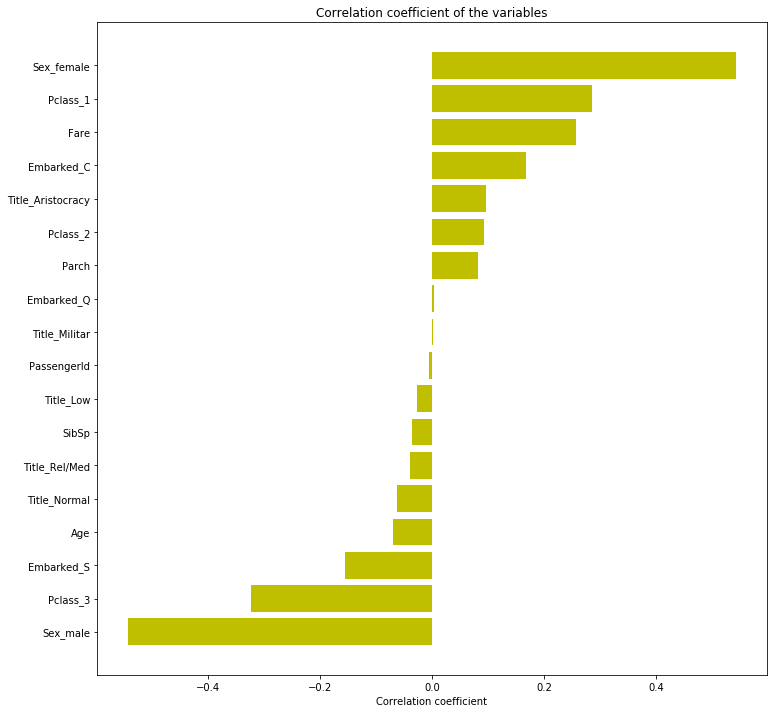

In [54]:
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(new_df[col],y.Survived.values)[0,1])
corr_df = pd.DataFrame({"col_labels":labels, "corr_values":values})
corr_df = corr_df.sort_values(by="corr_values")

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,12))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

In [55]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.02)]

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [56]:
corr_df_sel

,col_labels,corr_values
9,Sex_male,-0.543351
7,Pclass_3,-0.322308
12,Embarked_S,-0.155660
1,Age,-0.069809
16,Title_Normal,-0.061385
17,Title_Rel/Med,-0.038299
2,SibSp,-0.035322
14,Title_Low,-0.026456
3,Parch,0.081629
6,Pclass_2,0.093349


In [57]:
corr_df_sel.columns, corr_df_sel.col_labels.tolist()

(Index(['col_labels', 'corr_values'], dtype='object'),
 ['Sex_male',
  'Pclass_3',
  'Embarked_S',
  'Age',
  'Title_Normal',
  'Title_Rel/Med',
  'SibSp',
  'Title_Low',
  'Parch',
  'Pclass_2',
  'Title_Aristocracy',
  'Embarked_C',
  'Fare',
  'Pclass_1',
  'Sex_female'])

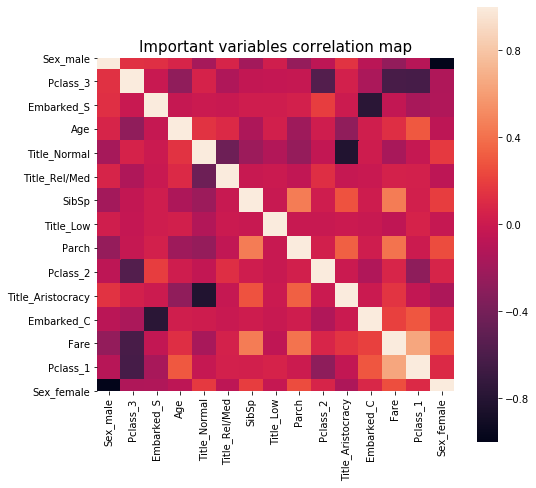

In [58]:
cols_to_use = corr_df_sel.col_labels.tolist()

selected_col_df = new_df[cols_to_use]
corrmat = selected_col_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [36]:
# how do I explode this graph ??

In [59]:
selected_col_df.head()

,Sex_male,Pclass_3,Embarked_S,Age,Title_Normal,Title_Rel/Med,SibSp,Title_Low,Parch,Pclass_2,Title_Aristocracy,Embarked_C,Fare,Pclass_1,Sex_female
0,1,1,1,22.0,1,0,1,0,0,0,0,0,7.2500,0,0
1,0,0,0,38.0,1,0,1,0,0,0,0,1,71.2833,1,1
2,0,1,1,26.0,1,0,0,0,0,0,0,0,7.9250,0,1
3,0,0,1,35.0,1,0,1,0,0,0,0,0,53.1000,1,1
4,1,1,1,35.0,1,0,0,0,0,0,0,0,8.0500,0,0


In [60]:
selected_col_df.shape

(891, 15)

# 2- First models in applicatiton

In [42]:
# Data preprocessing can be done with following method
kaggle_df = pd.read_csv("train.csv")
y = kaggle_df[["Survived"]]
selected_col_df, mean_df_age, title_class_mean_age_dict, cat_col_dum, cols_to_use = prepare_data(kaggle_df, is_train_df=True )

ekse


/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [44]:
x_train, x_test , y_train, y_test = train_test_split(selected_col_df,y, random_state=0)

In [45]:
x_train.shape, x_test.shape

((668, 15), (223, 15))

## Train Model v0 

In [46]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=1000 ).fit(x_train,y_train.Survived.values)
linear = LinearSVC(max_iter=10000).fit(x_train, y_train.Survived.values)
svc = SVC().fit(x_train, y_train.Survived.values)
rf = RandomForestClassifier(n_estimators=10).fit(x_train,y_train.Survived.values)
xgb = XGBClassifier().fit(x_train,y_train.Survived.values)

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [47]:
log_reg.score(x_train, y_train), log_reg.score(x_test, y_test)

(0.8368263473053892, 0.8116591928251121)

In [48]:
linear.score(x_train, y_train), linear.score(x_test, y_test)

(0.8383233532934131, 0.8026905829596412)

In [49]:
svc.score(x_train, y_train), svc.score(x_test, y_test)

(0.8937125748502994, 0.7354260089686099)

In [50]:
rf.score(x_train, y_train), rf.score(x_test, y_test)

(0.9625748502994012, 0.8161434977578476)

In [51]:
xgb.score(x_train, y_train), xgb.score(x_test, y_test)

(0.8832335329341318, 0.8430493273542601)

In [52]:
eval_set = [(x_train, y_train), (x_test, y_test)]
eval_metric = ["auc","error"]
%time xgb.fit(x_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.871814	validation_0-error:0.158683	validation_1-auc:0.892129	validation_1-error:0.183857
[1]	validation_0-auc:0.871956	validation_0-error:0.158683	validation_1-auc:0.894699	validation_1-error:0.183857
[2]	validation_0-auc:0.874442	validation_0-error:0.158683	validation_1-auc:0.896711	validation_1-error:0.183857
[3]	validation_0-auc:0.874471	validation_0-error:0.158683	validation_1-auc:0.894827	validation_1-error:0.183857
[4]	validation_0-auc:0.874735	validation_0-error:0.158683	validation_1-auc:0.894827	validation_1-error:0.183857
[5]	validation_0-auc:0.876527	validation_0-error:0.158683	validation_1-auc:0.894913	validation_1-error:0.183857
[6]	validation_0-auc:0.876527	validation_0-error:0.158683	validation_1-auc:0.894913	validation_1-error:0.183857
[7]	validation_0-auc:0.876527	validation_0-error:0.158683	validation_1-auc:0.894913	validation_1-error:0.183857
[8]	validation_0-auc:0.876612	validation_0-error:0.158683	validation_1-auc:0.894913	validation_1-error:0

[73]	validation_0-auc:0.931514	validation_0-error:0.134731	validation_1-auc:0.885963	validation_1-error:0.156951
[74]	validation_0-auc:0.931901	validation_0-error:0.134731	validation_1-auc:0.884849	validation_1-error:0.161435
[75]	validation_0-auc:0.932128	validation_0-error:0.134731	validation_1-auc:0.884507	validation_1-error:0.161435
[76]	validation_0-auc:0.932185	validation_0-error:0.134731	validation_1-auc:0.884335	validation_1-error:0.161435
[77]	validation_0-auc:0.932478	validation_0-error:0.137725	validation_1-auc:0.884335	validation_1-error:0.161435
[78]	validation_0-auc:0.932431	validation_0-error:0.137725	validation_1-auc:0.884592	validation_1-error:0.156951
[79]	validation_0-auc:0.932846	validation_0-error:0.136228	validation_1-auc:0.884421	validation_1-error:0.152466
[80]	validation_0-auc:0.93278	validation_0-error:0.136228	validation_1-auc:0.884335	validation_1-error:0.156951
[81]	validation_0-auc:0.932875	validation_0-error:0.134731	validation_1-auc:0.884592	validation_1

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

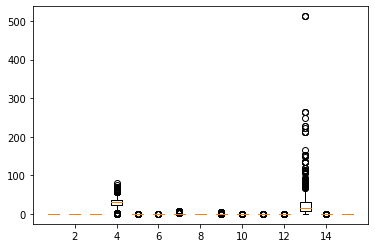

In [53]:
plt.boxplot(x_train.values, manage_ticks=False)
#plt.yscale("symlog")
plt.show()

In [54]:
x_train.columns

Index(['Sex_male', 'Pclass_3', 'Embarked_S', 'Age', 'Title_Normal',
       'Title_Rel/Med', 'SibSp', 'Title_Low', 'Parch', 'Pclass_2',
       'Title_Aristocracy', 'Embarked_C', 'Fare', 'Pclass_1', 'Sex_female'],
      dtype='object')

In [55]:
from sklearn.preprocessing import MinMaxScaler

In [56]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_trained_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

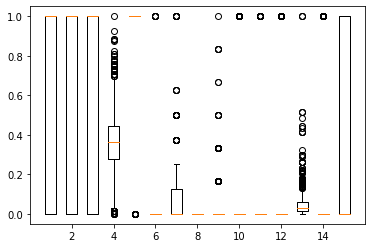

In [57]:
plt.boxplot(x_trained_scaled, manage_ticks=False)
plt.show()

In [58]:
log_reg_sc = LogisticRegression().fit(x_trained_scaled, y_train.Survived.values)
linear_sc = LinearSVC().fit(x_trained_scaled, y_train.Survived.values)
svm_sc = SVC().fit(x_trained_scaled, y_train.Survived.values)
rf_sc = RandomForestClassifier(n_estimators=10).fit(x_train,y_train.Survived.values)

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [59]:
log_reg_sc.score(x_trained_scaled, y_train), log_reg_sc.score(x_test_scaled,y_test),\
log_reg.score(x_train, y_train), log_reg.score(x_test, y_test)

(0.8398203592814372,
 0.8161434977578476,
 0.8368263473053892,
 0.8116591928251121)

In [60]:
linear_sc.score(x_trained_scaled, y_train), linear_sc.score(x_test_scaled,y_test),\
linear.score(x_train, y_train), linear.score(x_test, y_test)

(0.8398203592814372,
 0.8116591928251121,
 0.8383233532934131,
 0.8026905829596412)

In [61]:
svm_sc.score(x_trained_scaled, y_train), svm_sc.score(x_test_scaled,y_test),\
svc.score(x_train, y_train), svc.score(x_test, y_test)

(0.811377245508982, 0.7802690582959642, 0.8937125748502994, 0.7354260089686099)

In [62]:
rf_sc.score(x_trained_scaled, y_train), rf_sc.score(x_test_scaled,y_test),\
rf.score(x_train, y_train), rf.score(x_test,y_test)

(0.7170658682634731,
 0.7354260089686099,
 0.9625748502994012,
 0.8161434977578476)

# 3- Grid search

In [63]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## LogisticRegression

In [64]:
log_reg_grid = {'penalty': ["l1", "l2"], 'C':[0.001, 0.01, 0.1, 1, 10,100], "max_iter":[1000,10000]}
log_reg_gs = GridSearchCV(LogisticRegression(), log_reg_grid, cv=3)
log_reg_gs.fit(x_train, y_train.Survived.values)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000, 10000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [65]:
log_reg_gs.best_params_

{'C': 1, 'max_iter': 1000, 'penalty': 'l1'}

In [66]:
log_reg_gs.best_score_, log_reg_gs.score(x_train, y_train), log_reg_gs.score(x_test,y_test)

(0.8233532934131736, 0.8368263473053892, 0.8116591928251121)

## LinearSVC

In [67]:
gris_linSVC = {'penalty': ["l1", "l2"], 'C':[0.001, 0.01, 0.1, 1, 10,100], "max_iter":[1000,10000]}
gs_linSVC = GridSearchCV(LinearSVC(dual=False), gris_linSVC, cv=3)
gs_linSVC.fit(x_train, y_train.Survived.values)

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000, 10000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [68]:
gs_linSVC.best_params_

{'C': 1, 'max_iter': 1000, 'penalty': 'l2'}

In [69]:
gs_linSVC.best_score_, gs_linSVC.score(x_train, y_train.Survived.values), gs_linSVC.score(x_test,y_test.Survived.values)

(0.8323353293413174, 0.8383233532934131, 0.8116591928251121)

In [70]:
pd.DataFrame(gs_linSVC.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002118,0.000170,0.000835,0.000075,0.001,1000,l1,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l1'}",0.659193,0.663677,0.666667,0.663174,0.003071,23
1,0.002264,0.000115,0.000813,0.000018,0.001,1000,l2,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'}",0.699552,0.757848,0.720721,0.726048,0.024112,21
2,0.001682,0.000097,0.000737,0.000061,0.001,10000,l1,"{'C': 0.001, 'max_iter': 10000, 'penalty': 'l1'}",0.659193,0.663677,0.666667,0.663174,0.003071,23
3,0.002426,0.000270,0.001112,0.000161,0.001,10000,l2,"{'C': 0.001, 'max_iter': 10000, 'penalty': 'l2'}",0.699552,0.757848,0.720721,0.726048,0.024112,21
4,0.002053,0.000270,0.001031,0.000176,0.01,1000,l1,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l1'}",0.744395,0.802691,0.788288,0.778443,0.024809,19
5,0.002281,0.000474,0.000746,0.000088,0.01,1000,l2,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",0.780269,0.816143,0.828829,0.808383,0.020564,17
6,0.002177,0.000185,0.000907,0.000160,0.01,10000,l1,"{'C': 0.01, 'max_iter': 10000, 'penalty': 'l1'}",0.744395,0.802691,0.788288,0.778443,0.024809,19
7,0.002306,0.000252,0.000739,0.000017,0.01,10000,l2,"{'C': 0.01, 'max_iter': 10000, 'penalty': 'l2'}",0.780269,0.816143,0.828829,0.808383,0.020564,17
8,0.002887,0.000820,0.000850,0.000018,0.1,1000,l1,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1'}",0.798206,0.825112,0.860360,0.827844,0.025438,15
9,0.002252,0.000017,0.000705,0.000026,0.1,1000,l2,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}",0.811659,0.820628,0.860360,0.830838,0.021148,11


## SVM

In [71]:
svm_grid = {"C": [0.001, 0.01, 0.1, 1, 10], "gamma": [0.001, 0.01, 0.1, 1, 10]}

In [72]:
gs_svm = GridSearchCV(SVC(), svm_grid, cv=3)

In [73]:
gs_svm.fit(x_trained_scaled, y_train.Survived.values)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [74]:
gs_svm.best_params_

{'C': 10, 'gamma': 1}

In [75]:
gs_svm.best_score_, gs_svm.score(x_trained_scaled,y_train.Survived.values), gs_svm.score(x_test_scaled,y_test.Survived.values)

(0.8323353293413174, 0.8562874251497006, 0.8251121076233184)

In [144]:
pd.DataFrame(gs_svm.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004857,0.000387,0.001918,0.000034,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.602679,0.603604,0.603604,0.603293,0.000437,13
1,0.004385,0.000051,0.001899,0.000026,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.602679,0.603604,0.603604,0.603293,0.000437,13
2,0.004454,0.000085,0.001884,0.000070,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.602679,0.603604,0.603604,0.603293,0.000437,13
3,0.005095,0.000651,0.002387,0.000388,0.001,1,"{'C': 0.001, 'gamma': 1}",0.602679,0.603604,0.603604,0.603293,0.000437,13
4,0.005057,0.000364,0.002007,0.000200,0.001,10,"{'C': 0.001, 'gamma': 10}",0.602679,0.603604,0.603604,0.603293,0.000437,13
5,0.004311,0.000065,0.001796,0.000016,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.602679,0.603604,0.603604,0.603293,0.000437,13
6,0.004068,0.000121,0.001722,0.000060,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.602679,0.603604,0.603604,0.603293,0.000437,13
7,0.004047,0.000099,0.001779,0.000191,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.602679,0.603604,0.603604,0.603293,0.000437,13
8,0.004256,0.000129,0.001761,0.000080,0.01,1,"{'C': 0.01, 'gamma': 1}",0.602679,0.603604,0.603604,0.603293,0.000437,13
9,0.004229,0.000131,0.001682,0.000016,0.01,10,"{'C': 0.01, 'gamma': 10}",0.602679,0.603604,0.603604,0.603293,0.000437,13


## Random Forest

In [76]:
rf_grid = {"n_estimators": [10,20,40,80,100,500,1000], 'max_depth':[None,2,4, 6, 10,20]}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=0), rf_grid)
gs_rf.fit(x_train, y_train.Survived.values)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_gri

In [77]:
gs_rf.best_params_

{'max_depth': 6, 'n_estimators': 500}

In [78]:
gs_rf.best_score_, gs_rf.score(x_train,y_train), gs_rf.score(x_test, y_test)

(0.8323353293413174, 0.8577844311377245, 0.8295964125560538)

In [79]:
gs_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [80]:
gs_rf.best_estimator_.feature_importances_

array([0.22872979, 0.08001392, 0.02013242, 0.09670179, 0.01773409,
       0.00232097, 0.05431874, 0.        , 0.03182833, 0.02038089,
       0.02607722, 0.01419765, 0.12055467, 0.03951155, 0.24749798])

In [82]:
results = pd.DataFrame(gs_rf.cv_results_)
scores = np.array(results.mean_test_score).reshape(6,7)

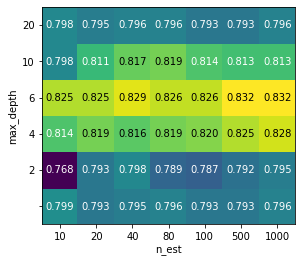

In [83]:
mglearn.tools.heatmap(scores, xlabel="n_est", xticklabels=rf_grid["n_estimators"], ylabel="max_depth", yticklabels=rf_grid["max_depth"],fmt='%0.3f')
plt.show()

In [84]:
feature_importances = pd.DataFrame(gs_rf.best_estimator_.feature_importances_,
                                  index=x_train.columns,
                                  columns=["importance"]).sort_values("importance", ascending=False)

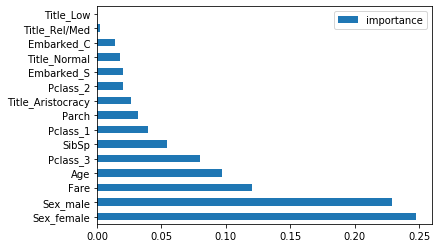

In [85]:
feature_importances.plot.barh()
plt.show()

## XGBoost Forest

In [86]:
#xgb_grid = {"learning_rate": [0.1, 0.01], "n_estimators": [100, 500, 1000,5000], "max_depth":[3,4,5, 6]}
xgb_grid = {"n_estimators": [100, 500, 1000,5000], "max_depth":[3,4,5, 6]}
xgb_gs = GridSearchCV(XGBClassifier(), xgb_grid)
xgb_gs.fit(x_train, y_train)

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 500, 1000, 5000]},
             pre_dispatch='2*n_jobs', refit=

In [87]:
xgb_gs.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [88]:
xgb_gs.best_score_, xgb_gs.score(x_train,y_train), xgb_gs.score(x_test, y_test)

(0.8248502994011976, 0.9146706586826348, 0.8565022421524664)

In [89]:
xgb_gs.best_estimator_.feature_importances_

array([0.47913808, 0.15656951, 0.04574495, 0.02186857, 0.        ,
       0.        , 0.07700597, 0.        , 0.01591336, 0.        ,
       0.1100264 , 0.01459543, 0.03089395, 0.04824371, 0.        ],
      dtype=float32)

In [90]:
feature_importances = pd.DataFrame(xgb_gs.best_estimator_.feature_importances_,
                                  index=x_train.columns,
                                  columns=["importance"]).sort_values("importance", ascending=False)

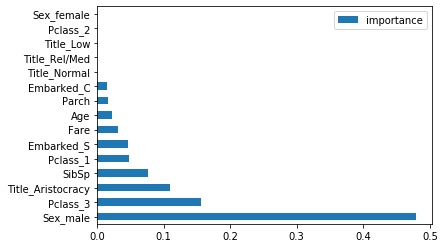

In [91]:
feature_importances.plot.barh()
plt.show()

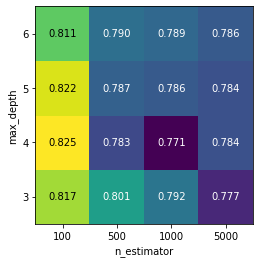

In [92]:
results = pd.DataFrame(xgb_gs.cv_results_)
scores = np.array(results.mean_test_score).reshape(4,4)
mglearn.tools.heatmap(scores, xlabel='n_estimator', xticklabels=xgb_grid["n_estimators"], ylabel="max_depth",yticklabels=xgb_grid["max_depth"], fmt='%0.3f')
plt.show()

# 4- Kaggle Test Data

In [101]:
!ls

README.md             gender_submission.csv titanic_train.ipynb
cache                 test.csv              train.csv


## Final XGBoost model

In [109]:
kaggle_df = pd.read_csv("train.csv")
y_kaggle_df = kaggle_df[["Survived"]]
train_kaggle_df, mean_df_age, title_class_mean_age_dict, cat_col_dum, cols_to_use = prepare_data(kaggle_df, is_train_df=True )

In [110]:
xgb_gs.best_estimator_.feature_importances_

array([0.47913808, 0.15656951, 0.04574495, 0.02186857, 0.        ,
       0.        , 0.07700597, 0.        , 0.01591336, 0.        ,
       0.1100264 , 0.01459543, 0.03089395, 0.04824371, 0.        ],
      dtype=float32)

In [111]:
xgb_gs.best_estimator_.fit(train_kaggle_df,y_kaggle_df )

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [112]:
xgb_gs.best_estimator_.feature_importances_

array([0.44317114, 0.20037015, 0.02447629, 0.01987714, 0.01726819,
       0.        , 0.0513255 , 0.        , 0.00977498, 0.02851988,
       0.09960765, 0.01503597, 0.02857517, 0.06199793, 0.        ],
      dtype=float32)

In [113]:
test_kaggle_df = pd.read_csv("test.csv")

In [114]:
test_kaggle_prepared_df, mean_df_age, title_class_mean_age_dict, cat_col_dum, cols_to_use = prepare_data(test_kaggle_df,
                                                                                                               False,
                                                                                                               mean_df_age,
                                                                                                               title_class_mean_age_dict,
                                                                                                               cat_col_dum,
                                                                                                               cols_to_use
                                                                                                              )

In [115]:
xgbs_result_df = pd.DataFrame({"PassengerId":test_kaggle_df.PassengerId.values,
                          "Survived":xgb_gs.predict(test_kaggle_prepared_df)})

In [116]:
xgbs_result_df.Survived.value_counts()

0    274
1    144
Name: Survived, dtype: int64

In [117]:
xgbs_result_df.to_csv("result_xgbs.csv", index=False)

## Final model LinearSVC

In [119]:
from sklearn.base import clone

In [120]:
final_model1 = clone(gs_linSVC.best_estimator_)
final_model1.fit(x_train, y_train)

/Users/antoine/Documents/Tests/python/ML/venv3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [123]:
result1_df = pd.DataFrame({"PassengerId":test_df.PassengerId.values,
                          "Survived":final_model1.predict(test_kaggle_df)})

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [334]:
result1_df.tail(3)

,PassengerId,Survived
415,1307,0
416,1308,0
417,1309,0


In [335]:
result1_df.to_csv("result4.csv", index=False)

In [ ]:
#=> 0.78947

## Final model Random Forest

In [124]:
final_model = RandomForestClassifier(n_estimators=20, max_depth=6)

In [125]:
final_model.fit(selected_col_df,y.Survived.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [126]:
final_model.score(selected_col_df,y.Survived.values)

0.8641975308641975

In [127]:
from sklearn.model_selection import cross_val_score
cross_val_score(final_model, selected_col_df,y.Survived.values )

array([0.81144781, 0.83838384, 0.82154882])